# models

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)


# utils

In [2]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np

def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)



class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


# Train

In [3]:
import os
import itertools
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import weights_init_normal

import time
start_time = time.time()

if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

# parameters
#TODO : set up all the parameters
epochs = 100    # number of epochs of training
batchsize = 40    # size of the batches
animation_root =  './animation_/'   # root directory of the dataset
cartoon_root =  './cartoon_/'   # root directory of the dataset
lr =  3e-4   # initial learning rate
size =  32   # size of the data crop (squared assumed)
input_nc = 3    # number of channels of input data
output_nc = 3   # number of channels of output data
#lambda_cyc= 10    # cycle loss weight
#lambda_id = 5    # identity loss weight


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)
###################################
G_loss  = []
DA_loss  = []
DB_loss  = []
###### Training ######
for epoch in range(1, epochs):
    i=1
    print('epoch',epoch)
    for batch in zip(animation_loader, cartoon_loader):
        # Set model input
        A = torch.FloatTensor(batch[0][0])
        B = torch.FloatTensor(batch[1][0])
        real_A = Variable(input_A.copy_(A)).cuda()
        real_B = Variable(input_B.copy_(B)).cuda()

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        # TODO : calculate the loss for the generators, and assign to loss_G
        '''↓'''
        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        '''↑'''
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # TODO : calculate the loss for a discriminator, and assign to loss_D_A
        '''↓'''
        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()
        
        '''↑'''
        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # TODO : calculate the loss for the other discriminator, and assign to loss_D_B
        '''↓'''
        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        
        '''↑'''
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        G_loss.append(loss_G.data)
        DA_loss.append(loss_D_A.data)
        DB_loss.append(loss_D_B.data.data)
        # Progress report
        if (i%10==0):
            print("loss_G : ",loss_G.data.cpu().numpy() ,",loss_D:", (loss_D_A.data.cpu().numpy() + loss_D_B.data.cpu().numpy()))
            i=0
        i=i+1
    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'ckpt/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'ckpt/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'ckpt/netD_A.pth')
    torch.save(netD_B.state_dict(), 'ckpt/netD_B.pth')
    
end_time = time.time()
print('Total cost time',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

# TODO : plot the figure
'''↓'''
# plt generator loss
plt.plot(G_loss, label = "Generator")
plt.title("Loss of Generator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

# plt Discriminator loss
plt.plot(DA_loss, label = "Discriminator A")
plt.plot(DB_loss, label = "Discriminator B")
plt.title("Loss of Discriminator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()
'''↑'''

/mnt/sdb/Su/Homework/DLHW3/utils.py:44: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


epoch 1


/opt/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_G :  11.919737 ,loss_D: 0.5540173
loss_G :  10.712435 ,loss_D: 0.7342973
loss_G :  10.433934 ,loss_D: 0.20150709
loss_G :  9.426958 ,loss_D: 0.2540071
loss_G :  15.417944 ,loss_D: 1.5399216
loss_G :  9.647629 ,loss_D: 0.15389657
loss_G :  7.9679227 ,loss_D: 0.5912001
loss_G :  8.021716 ,loss_D: 0.12218927
loss_G :  8.782838 ,loss_D: 0.11211029
loss_G :  8.138694 ,loss_D: 0.13112979
loss_G :  10.427282 ,loss_D: 0.66093135
loss_G :  8.062245 ,loss_D: 0.109532595
loss_G :  8.728588 ,loss_D: 0.47772992
loss_G :  7.554118 ,loss_D: 0.81581473
loss_G :  8.792279 ,loss_D: 0.5788125
loss_G :  7.12696 ,loss_D: 0.24308167
loss_G :  8.562115 ,loss_D: 0.7849231
loss_G :  7.2536674 ,loss_D: 0.39416504
loss_G :  7.560184 ,loss_D: 0.31124425
loss_G :  6.9344215 ,loss_D: 0.41847694
loss_G :  7.094416 ,loss_D: 0.29854286
loss_G :  7.812958 ,loss_D: 0.37746108
loss_G :  6.6013956 ,loss_D: 0.3437306
loss_G :  6.1737847 ,loss_D: 0.49007386
loss_G :  6.3673196 ,loss_D: 0.3254894
epoch 2
loss_G :  6.362

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

'↑'

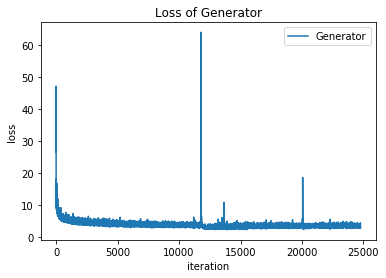

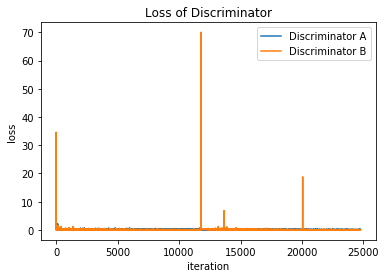

In [5]:
# plt generator loss
plt.plot(G_loss, label = "Generator")
plt.title("Loss of Generator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

# plt Discriminator loss
plt.plot(DA_loss, label = "Discriminator A")
plt.plot(DB_loss, label = "Discriminator B")
plt.title("Loss of Discriminator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

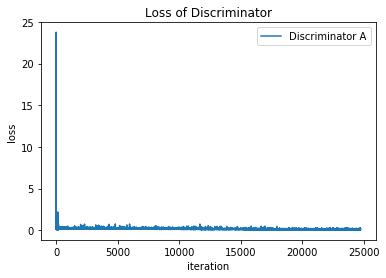

In [6]:
# plt Discriminator loss
plt.plot(DA_loss, label = "Discriminator A")
#plt.plot(DB_loss, label = "Discriminator B")
plt.title("Loss of Discriminator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

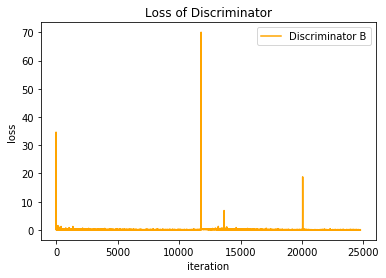

In [8]:
# plt Discriminator loss
#plt.plot(DA_loss, label = "Discriminator A")
plt.plot(DB_loss, label = "Discriminator B", color = 'orange')
plt.title("Loss of Discriminator")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

# Test

In [4]:
from torchvision.utils import save_image
import os
import sys

import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import weights_init_normal
###### Definition of variables ######
# TODO : assign input_nc and output_nc
'''↓'''

input_nc = 3
output_nc = 3

'''↑'''

# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)

# Load state dicts
netG_A2B.load_state_dict(torch.load('ckpt/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('ckpt/netG_B2A.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG_A2B.to(device)
netG_B2A.to(device)

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)


if not os.path.exists('output/animation'):
    os.makedirs('output/animation')
if not os.path.exists('output/cartoon'):
    os.makedirs('output/cartoon')

i = 0
for batch in zip(animation_loader, cartoon_loader):
    # Set model input
    A = torch.FloatTensor(batch[0][0])
    B = torch.FloatTensor(batch[1][0])
    real_A = Variable(input_A.copy_(A))
    real_B = Variable(input_B.copy_(B))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(real_A, 'output/animation/real%04d.png' % (i+1))
    save_image(real_B, 'output/cartoon/real%04d.png' % (i+1))
    save_image(fake_A, 'output/animation/fake%04d.png' % (i+1))
    save_image(fake_B, 'output/cartoon/fake%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d' % (i+1))
    i = i+1
    if (i==10):
        break

sys.stdout.write('\n')

Generated images 0010
